### Datadog Ragas Integration

Datadog's LLM Observability integration with the [Ragas](https://docs.ragas.io/en/stable/) evaluation framework enables developers to continuously evaluate their RAG applications in production.

In the following example, we'll instrument a RAG-powered application and enable the `ragas_faithfulness` evaluator to monitor for hallucinations.

#### Learning Goals

- Understand how to instrument a RAG application to enable the Ragas integration
- Understand how to use Datadog & Ragas to continuously monitor your LLM app in production

#### Why use Ragas for production monitoring?

Ragas scores for RAG performance are powered by LLM-as-a-judge methods. By running Ragas evaluations on your LLM Observability traces, you can 
1. Filter for traces that have a high likelihood of hallucinations
2. Review these traces to improve your augmented generation LLM steps
3. Track scores over time—and after critical changes to your RAG application (e.g. prompts)

### Setup and Prerequisites

Make sure you've followed the instructions in the [`README`](https://github.com/DataDog/llm-observability/blob/main/README.md) file to set up your environment to enable LLM Observability.

We'll also need to install some dependencies for this tutorial:

In [ ]:
%pip install llama-index=="0.10.42" ragas=="0.1.21" --quiet

### Enabling the Ragas Evaluations

Next, enable the Ragas faithfulness evaluations through the `DD_LLMOBS_EVALUATORS` environment variable:

In [2]:
import os
os.environ["DD_TRACE_ENABLED"] = "false"
os.environ["DD_LLMOBS_EVALUATORS"] = "ragas_faithfulness"

Enable LLM Observability tracing:

In [ ]:
from dotenv import load_dotenv

load_dotenv()

from ddtrace.llmobs import LLMObs

LLMObs.enable(ml_app="support-bot", agentless_enabled=True)

### What is Ragas faithfulness?

Faithfulness is a score that evaluates how consistent an LLM's generation is against some ground truth data. It requires the origin question fed into the LLM, the ground truth context information used in the LLM call, and the answer the LLM generated to the question.

The score is generated by 
1. Step 1 (Creating Statements) - Ask another LLM to break down the `answer` into individual statements
2. Step 2 (Creating Verdicts) - For each statement, determine if it can be inferred from the given context
3. Step 3 (Compute Score) - Divide the number of contradicting statements over the total number of statements

For more information, see the official [Ragas faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/faithfulness/) documentation.

### Create your RAG Application

We'll be creating a RAG bot to answer questions about LLM Observability.

First, fetch LLM Obs documentation [documentation](https://github.com/DataDog/documentation/tree/master) from Datadog's public docs repository. This will act as the knowledge base our RAG app uses to answer questions.

Make sure the following source URL and document names are up to date.

In [4]:
doc_names = [
    "_index",
    "api",
    "auto_instrumentation",
    "core_concepts",
    "quickstart",
    "sdk",
    "span_kinds",
    "submit_evaluations",
    "trace_an_llm_application",
]
raw_doc_source_url = "https://raw.githubusercontent.com/DataDog/documentation/master/content/en/llm_observability"

In [5]:
import requests
from llama_index.core import Document
from llama_index.core.node_parser import MarkdownNodeParser
from llama_index.core import Document
from llama_index.core import VectorStoreIndex

raw_doc_texts = []
for doc_name in doc_names:
    doc = requests.get(f"{raw_doc_source_url}/{doc_name}.md")
    raw_doc_texts.append(Document(text=doc.text))
parser = MarkdownNodeParser()
base_nodes = parser.get_nodes_from_documents(raw_doc_texts)

TOP_K = 2

base_index = VectorStoreIndex(base_nodes)
base_retriever = base_index.as_retriever(similarity_top_k=TOP_K)

### Step 1 - Instrumentation

We'll need to first instrument the data from our LLM calls will be evaluated for hallucations. 

The following code block contains an LLM call that uses retrieved ground truths to answer a question.

This LLM call will be automatically traced by Datadog's OpenAI integration as an [LLM Span](https://docs.datadoghq.com/llm_observability/terms/#llm-span). This span contains some core information such as the operation's duration, input messages, outputs, invocation parameters, etc. 

We'll also need to enrich this LLM span with prompt template information that captures the context used for the LLM call. This can be accomplished through the `annotation_context` method.

In [6]:
from ddtrace.llmobs import LLMObs
from ddtrace.llmobs.decorators import workflow
from ddtrace.llmobs.utils import Prompt


from openai import OpenAI

oai_client = OpenAI()

prompt_template = """
You are an engineer meant to answer support questions about a software product.
The product is LLM Observability by Datadog, a monitoring solution for LLM applications.

You have access to the following reference information: "{context}"
"""


def augmented_generation(question, context):
    with LLMObs.annotation_context(
        prompt=Prompt(variables={"context": context}),
        name="augmented_generation",
    ):
        answer = (
            oai_client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {
                        "role": "system",
                        "content": prompt_template.format(context=context),
                    },
                    {
                        "role": "user",
                        "content": question,
                    },
                ],
            )
            .choices[0]
            .message.content
        )
        return answer


@workflow
def ask_docs(question):
    nodes = base_retriever.retrieve(question)
    context = " ".join([node.text for node in nodes])
    answer = augmented_generation(question, context)
    LLMObs.annotate(input_data=question, output_data=answer)
    return answer

#### Instrumenting RAG Context for Ragas

Instrumenting the prompt template is a critical step as that is how the Datadog Ragas integration will pick up the required data used for the faithfulness evaluation

Any span to be evaluated by Ragas Faithfulness Evaluator must be instrumented with a `context` prompt template variable. This is because Ragas faithfulness scores are calculated from a question, answer, and context.

You can also optionally annotate the `question` template variable—if present, we'll use it as the `question` for the faithfulness evaluation. If it is not present, we'll assume the question is the latest message in the input messages array.

## Run your RAG app

Let's ask our RAG workflow a simple question on how to get started with LLM Observability.

In [7]:
STARTER_QUESTION = "How do I get started?"

answer = ask_docs(STARTER_QUESTION)

print("Answer: {}".format(answer))

Answer: To get started with LLM Observability by Datadog, you can follow these steps:

1. **Review Authorization**: Make sure to review the authorization notice that Datadog is authorized to share your company's data with OpenAI LLC for the purpose of providing and improving LLM Observability.

2. **Setup Documentation**: Refer to the [Setup documentation][5] for detailed instructions on instrumenting your LLM application.

3. **Trace an Application**: Follow the "Trace an LLM Application guide" to generate a trace using the [LLM Observability SDK for Python][3].

If you have any questions or concerns, feel free to reach out to your account representative for further assistance.


span_tags must be a dictionary of string key - primitive value pairs.


#### Look at RAGAS evaluation results in Datadog

We can now navigate to the Datadog UI and click on the `ask_docs` trace. You should see the `ragas_faithfulness` custom evaluation joined to the `augmented_generation` LLM span in the trace.

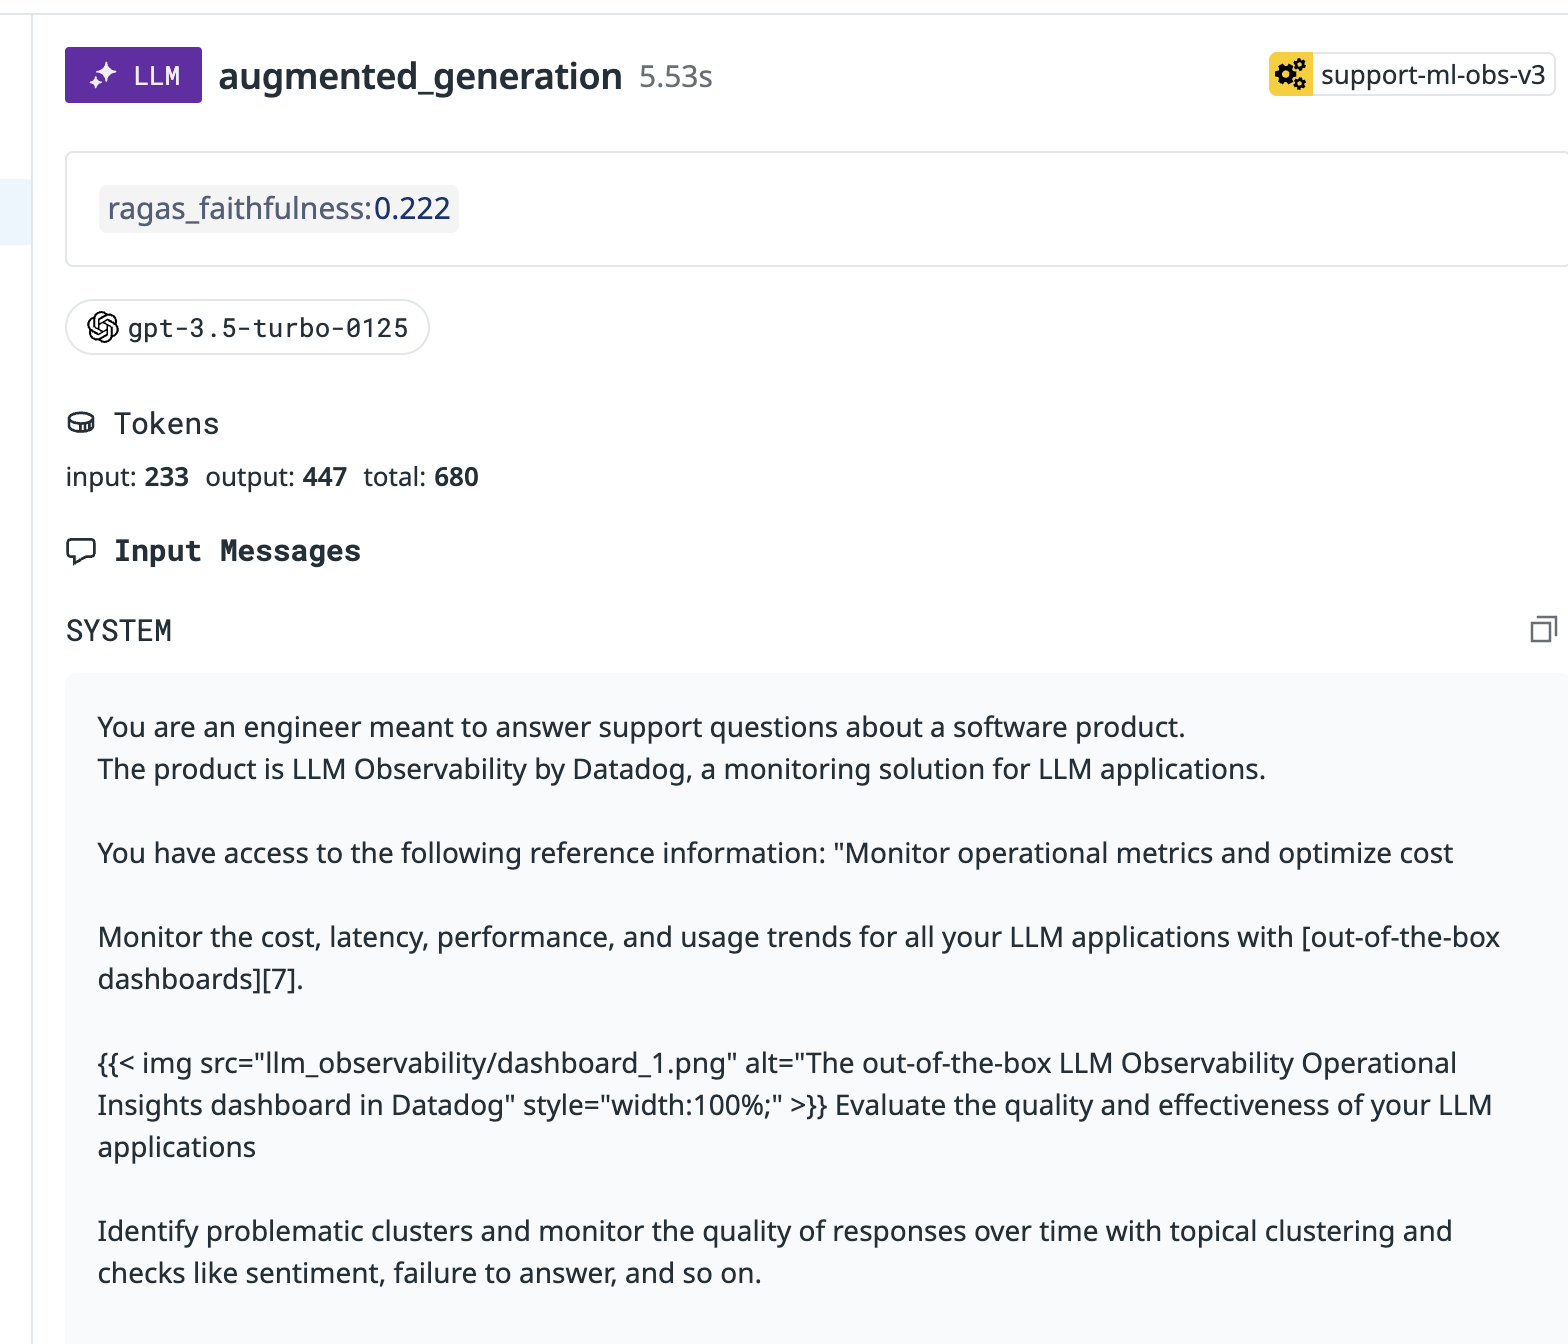


Check out the `dd-ragas-support-bot` ml application. This ml application should contain traces of the ragas evaluations themselves, explaining how the score you saw above was generated!

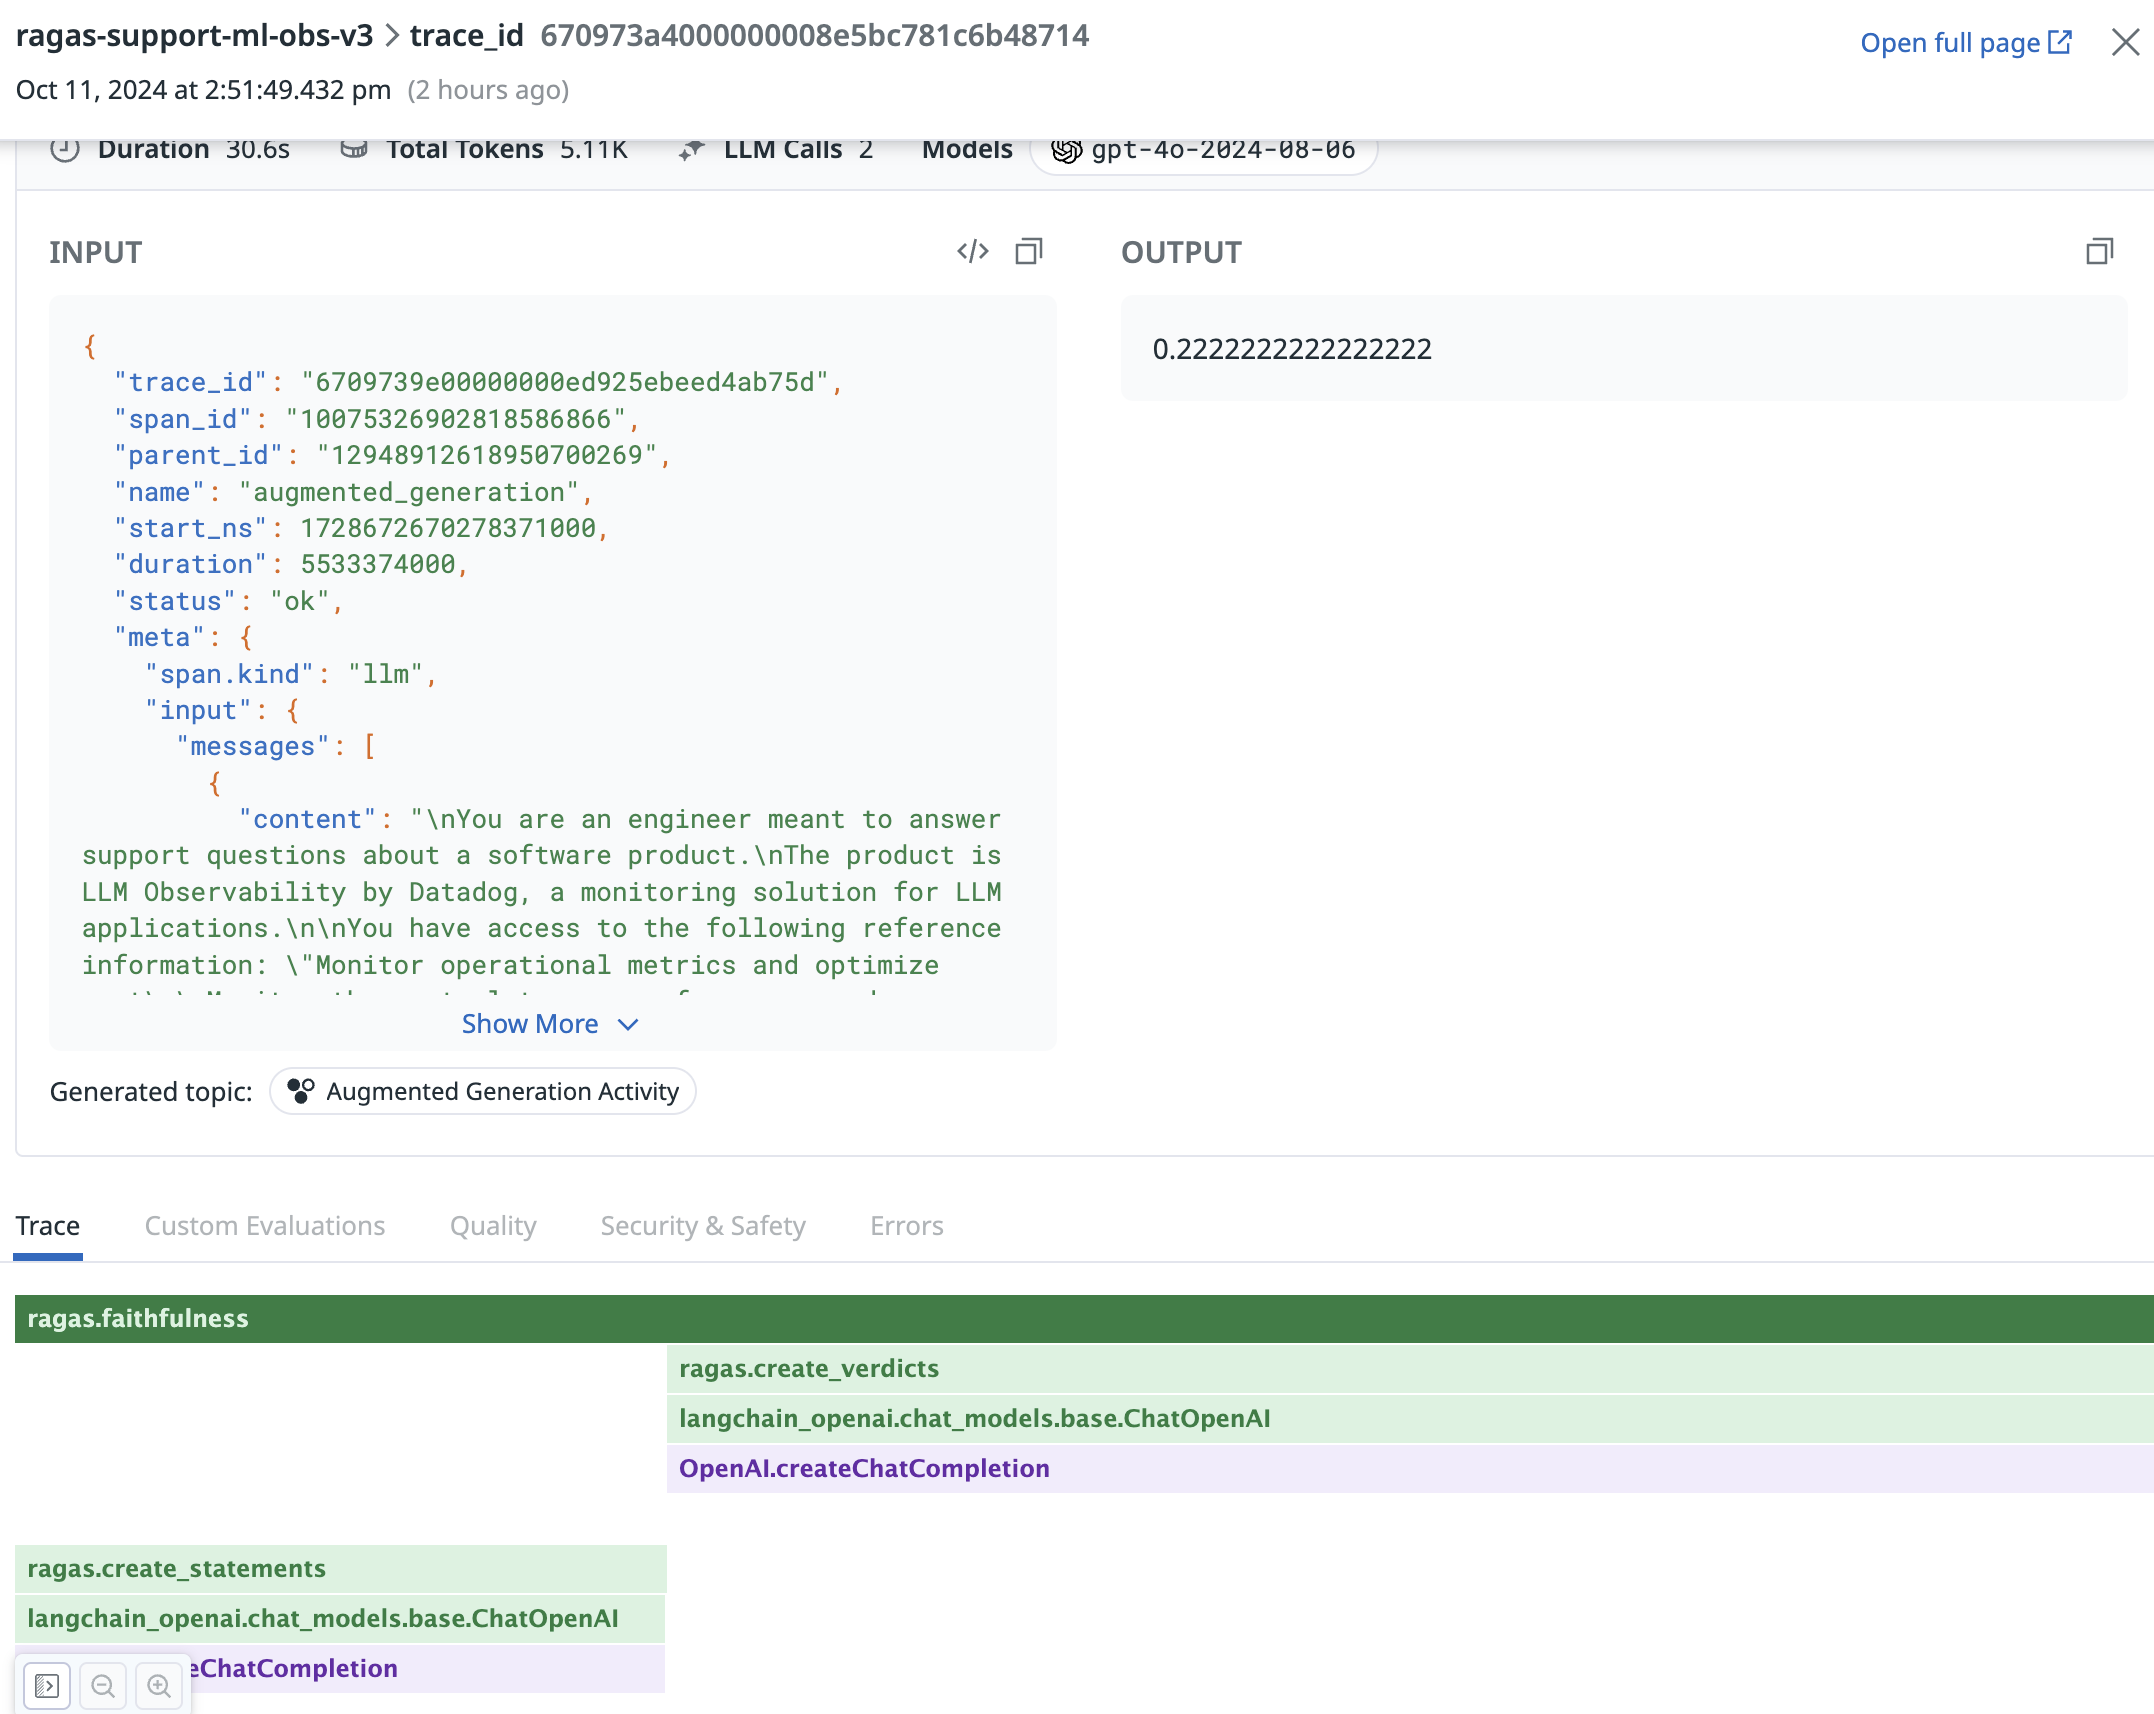